In [5]:
%matplotlib notebook
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import time
import matplotlib.patches as mpatches
import json
import random
import math
import os, psutil
from datetime import datetime

SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIG_SIZE = 14

# Burden VS accuracy

['0.025118864315095794', '0.03087842727671737', '0.03795861385781314', '0.04666223292703069', '0.057361525104486784', '0.07051408292993672', '0.08668242140342024', '0.1065580359007992', '0.13099097638483814', '0.1610262027560939', '0.1979482762069703', '0.2433362979605388', '0.29913144504086914', '0.3677199914775936', '0.4520353656360243', '0.5556836085104307', '0.6830975986418832', '0.8397266396270678', '1.0322695185890127', '0.0001', '0.00028840315031266055', '0.0008317637711026709', '0.00239883291901949', '0.006918309709189363', '0.0199526231496888']


<IPython.core.display.Javascript object>


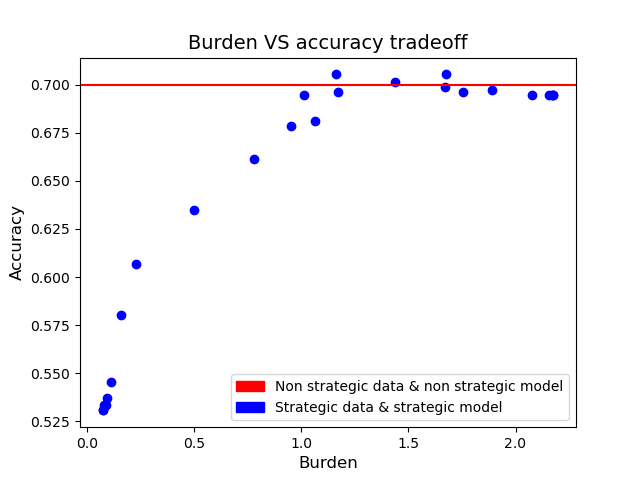

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [24]:
path = "./models/FINAL/burden/tradeoff"

burdens = []
accuracies = []
lambdas = []

for root,d_names,f_names in os.walk(path):
    if "val_burdens.csv" in f_names:
        lamb = root.split("/")[-1].split("_")[-1]
        lambdas.append(lamb)
        val_burdens = pd.read_csv(root + '/val_burdens.csv')
        burden = val_burdens.values[-1][1]
        burdens.append(burden)
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)

print(lambdas)

fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Burden VS accuracy tradeoff')
plt.xlabel('Burden')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.scatter(burdens, accuracies, color='b')
plt.axhline(y=0.7, linestyle='-', color='r')

red_patch = mpatches.Patch(color='r', label='Non strategic data & non strategic model')
blue_patch = mpatches.Patch(color='b', label='Strategic data & strategic model')

plt.legend(handles=[red_patch, blue_patch])
# plt.savefig(path + '/burden_vs_accuracy.pdf', format='pdf')
# plt.savefig(path + '/burden_vs_accuracy.eps', format='eps')
# plt.savefig(path + '/burden_vs_accuracy.png', format='png')
plt.show()

# Utility VS accuracy

['0.007943282347242814', '0.009459366861066257', '0.011264816923358862', '0.013414861922639128', '0.01597527253463916', '0.01902437267172322', '0.022655435440481153', '0.026979536400729993', '0.03212895140817722', '0.03826120298201575', '0.04556387897733956', '0.05426037096736028', '0.0646167078746697', '0.07694969389486886', '0.09163659965467225', '0.10912670306061635', '0.1299550328772239', '0.15475873545578883', '0.18429656527809932', '0.21947209553807595', '0.26136135878164596', '0.3112457631423002', '0.37065129109221545', '0.4413951798133092', '0.5256415111581286', '0.6259674117181422', '0.7454418880841288', '0.8877197088985865', '1.0571532055870385', '0.3981071705534972', '0.4190079105786669', '0.4410059454176737', '0.46415888336127786', '0.4885273571519389', '0.5141751827683926', '0.5411695265464637', '0.5695810810737686', '0.599484250318941', '0.6309573444801932', '0.48', '0.49', '0.5', '0.51', '0.5092500000000001']


<IPython.core.display.Javascript object>


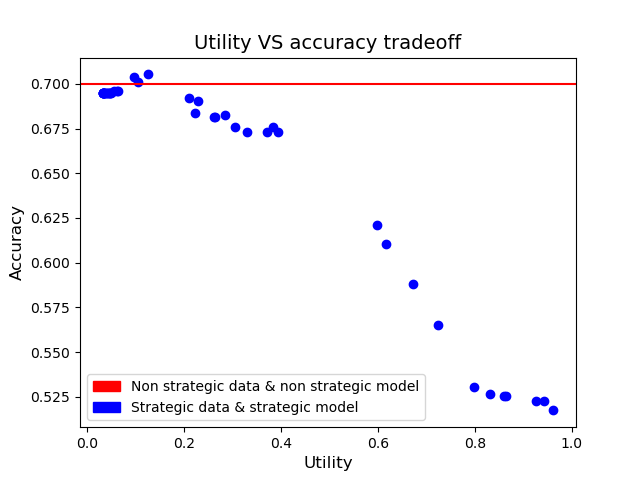

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [25]:
path = "./models/FINAL/utility/tradeoff"

utilities = []
accuracies = []
lambdas = []

for root,d_names,f_names in os.walk(path):
    if "val_utilities.csv" in f_names:
        lamb = root.split("/")[-1].split("_")[-1]
        lambdas.append(lamb)
        val_utilities = pd.read_csv(root + '/val_utilities.csv')
        utility = val_utilities.values[-1][1]
        utilities.append(utility)
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)

print(lambdas)
        
fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Utility VS accuracy tradeoff')
plt.xlabel('Utility')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.scatter(utilities, accuracies, color='b')
plt.axhline(y=0.7, linestyle='-', color='r')

red_patch = mpatches.Patch(color='r', label='Non strategic data & non strategic model')
blue_patch = mpatches.Patch(color='b', label='Strategic data & strategic model')

plt.legend(handles=[red_patch, blue_patch])
# plt.savefig(path + '/utility_vs_accuracy.pdf', format='pdf')
# plt.savefig(path + '/utility_vs_accuracy.eps', format='eps')
# plt.savefig(path + '/utility_vs_accuracy.png', format='png')
plt.show()

# Recourse VS accuracy

['0.0031622776601683794', '0.004012807031942776', '0.0050920956367733975', '0.006461670787466969', '0.008199608244604943', '0.010404983103657853', '0.013203517797162948', '0.01675474918923341', '0.021261123338996556', '0.026979536400729993', '0.03423597957607582', '0.043444122987293665', '0.05512889788770675', '0.06995642156712631', '0.08877197088985865', '0.11264816923358861', '0.1', '0.12798022139979537', '0.16378937069540642', '0.2096179992453127', '0.2682695795279726', '0.3433320018281994', '0.43939705607607904', '0.5623413251903491', '0.7196856730011522', '0.9210553176894818', '0.7943282347242815', '1.4962356560944334', '2.8183829312644537', '5.3088444423098835', '10.0', '1.0', '1.2', '1.4', '1.6', '1.8']


<IPython.core.display.Javascript object>


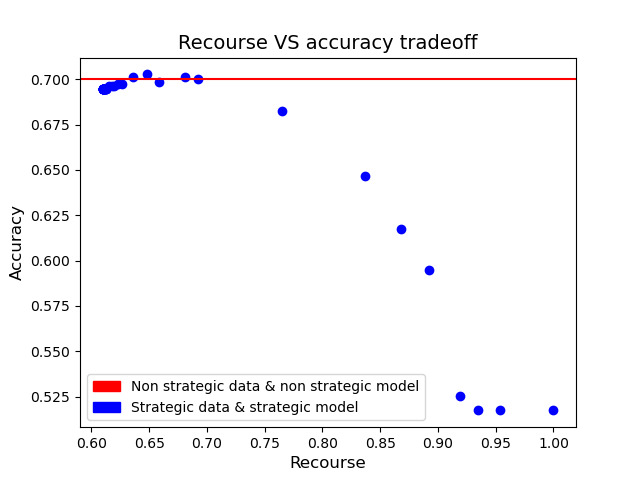

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:27: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [26]:
path = "./models/FINAL/recourse/tradeoff"

recourses = []
accuracies = []
lambdas = []

for root,d_names,f_names in os.walk(path):
    if "val_recourses.csv" in f_names:
        lamb = root.split("/")[-1].split("_")[-1]
        lambdas.append(lamb)
        val_recourses = pd.read_csv(root + '/val_recourses.csv')
        recourse = val_recourses.values[-1][1]
        recourses.append(recourse)
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)

print(lambdas)

fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Recourse VS accuracy tradeoff')
plt.xlabel('Recourse')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.scatter(recourses, accuracies, color='b')
plt.axhline(y=0.7, linestyle='-', color='r')

red_patch = mpatches.Patch(color='r', label='Non strategic data & non strategic model')
blue_patch = mpatches.Patch(color='b', label='Strategic data & strategic model')

plt.legend(handles=[red_patch, blue_patch])
# plt.savefig(path + '/recourse_vs_accuracy.pdf', format='pdf')
# plt.savefig(path + '/recourse_vs_accuracy.eps', format='eps')
# plt.savefig(path + '/recourse_vs_accuracy.png', format='png')
plt.show()

# Vanilla I

<IPython.core.display.Javascript object>


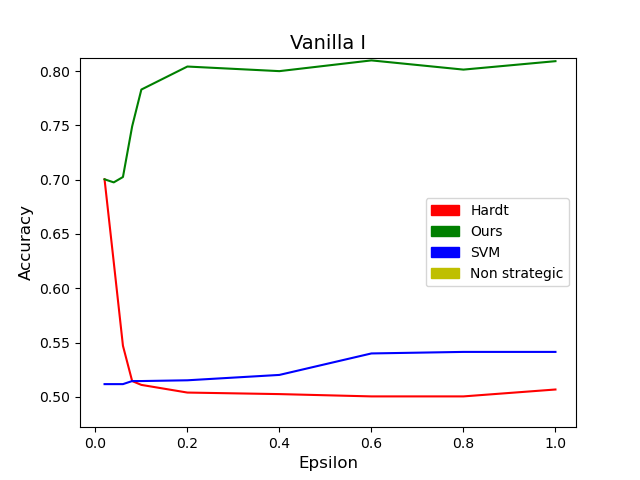

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [70]:
path = "./models/FINAL/vanilla_I/vanilla_vs_hardt_final_mid_scale0"

non_strategic_acc = 0.8239 # sklearn accuracy
epsilons = []
hardt_acc = []
ours_acc = []
svm_acc = []

for root,d_names,f_names in os.walk(path):
    if "results.csv" in f_names:
        details = root.split("\\")
        epsilon = float(details[-1])
        acc = pd.read_csv(root + '/results.csv')
        acc = acc.values[:, 1]
        epsilons.append(epsilon)
        hardt_acc.append(acc[1])
        ours_acc.append(acc[2])
        svm_acc.append(acc[3])

        
fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Vanilla I')
plt.xlabel('Epsilon')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.plot(epsilons, hardt_acc, color='r')
ax.plot(epsilons, ours_acc, color='g')
ax.plot(epsilons, svm_acc, color='b')

plt.axhline(y=non_strategic_acc, linestyle='-', color='y')

red_patch = mpatches.Patch(color='r', label='Hardt')
green_patch = mpatches.Patch(color='g', label='Ours')
blue_patch = mpatches.Patch(color='b', label='SVM')
yellow_patch = mpatches.Patch(color='y', label='Non strategic')

plt.legend(handles=[red_patch, green_patch, blue_patch, yellow_patch])

# plt.savefig(path + '/vanilla_vs_hardt.pdf', format='pdf')
# plt.savefig(path + '/vanilla_vs_hardt.eps', format='eps')
# plt.savefig(path + '/vanilla_vs_hardt.png', format='png')
plt.show()
        

# Vanilla II

<IPython.core.display.Javascript object>


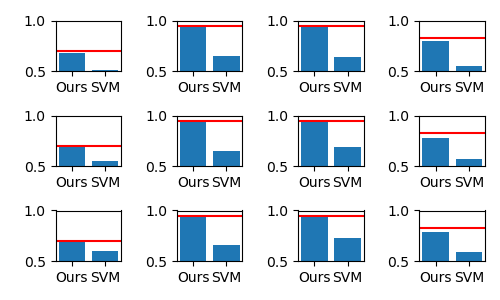

credit 0.7133333333333333
credit 0.7133333333333333
credit 0.7133333333333333
distress 0.9345238095238096
distress 0.9345238095238096
distress 0.9345238095238096
fraud 0.9319727891156462
fraud 0.9319727891156462
fraud 0.9319727891156462
spam 0.8239104829210836
spam 0.8239104829210836
spam 0.8239104829210836


In [59]:
path = "./models/FINAL/vanilla_II"
all_results = dict()
splits = 6

svm_accuracies = pd.read_csv(path + '/svm_accuracies.csv').values[:, 1]

for root,d_names,f_names in os.walk(path):
    if "results.csv" in f_names:
        details = root.split("\\")
        scale = details[-1]
        dataset = details[-3]
        acc = pd.read_csv(root + '/results.csv')
        acc = acc.values[:, 1]
        if (scale, dataset) not in all_results:
            all_results[(scale, dataset)] = np.zeros(3)
        all_results[(scale, dataset)] += acc

for key in all_results:
    all_results[key] /= splits

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(5, 3))

for i, (scale, dataset) in enumerate(all_results):
    row = i % 3
    col = i // 3
    axes[row, col].bar(["Ours", "SVM"], all_results[(scale, dataset)][1:])
    axes[row, col].set_ylim(0.5, 1) 
    axes[row, col].axhline(y=svm_accuracies[col], linestyle='-', color='r')
    
fig.tight_layout()

plt.show()

# Flexibility

In [4]:
path = "./models/FINAL/flexibility/simple"

accuracies = pd.read_csv(path + '/results.csv')
accuracies = accuracies.values[:, 1]
non_strategic_acc = accuracies[0]
oracle_acc = accuracies[1]
fixed_acc = accuracies[2]
flexible_acc = accuracies[3]

print("accuracies: ", non_strategic_acc, oracle_acc, fixed_acc, flexible_acc)

non_strategic_model_w = pd.read_csv(path + '/non_strategic_model_w.csv').values[:, 1:]
non_strategic_model_b = pd.read_csv(path + '/non_strategic_model_b.csv').values[:, 1]
strategic_model_oracle_w = pd.read_csv(path + '/strategic_model_oracle_w.csv').values[:, 1:]
strategic_model_oracle_b = pd.read_csv(path + '/strategic_model_oracle_b.csv').values[:, 1]
strategic_model_fixed_w = pd.read_csv(path + '/strategic_model_fixed_w.csv').values[:, 1:]
strategic_model_fixed_b = pd.read_csv(path + '/strategic_model_fixed_b.csv').values[:, 1]
strategic_model_flex_w = pd.read_csv(path + '/strategic_model_flex_w.csv').values[:, 1:]
strategic_model_flex_b = pd.read_csv(path + '/strategic_model_flex_b.csv').values[:, 1]

print("non_strategic_model_w: ", non_strategic_model_w)
print("non_strategic_model_b: ", non_strategic_model_b)
print("strategic_model_oracle_w: ", strategic_model_oracle_w)
print("strategic_model_oracle_b: ", strategic_model_oracle_b)
print("strategic_model_fixed_w: ", strategic_model_fixed_w)
print("strategic_model_fixed_b: ", strategic_model_fixed_b)
print("strategic_model_flex_w: ", strategic_model_flex_w)
print("strategic_model_flex_b: ", strategic_model_flex_b)

v_0 = pd.read_csv(path + '/flexible/v_orig.csv').values[:, 1:]
v_learned = pd.read_csv(path + '/flexible/v.csv').values[:, 1:]

print("v_0: ", v_0)
print("v_learned: ", v_learned)

"""
----- Data ----
pos_points:
mu_x = 0.5
mu_y = 0
sig_x = 0.1
sig_y = 1

neg_points:
mu_x = -0.5
mu_y = 0
sig_x = 0.1
sig_y = 1
""" 

accuracies:  1.0 1.0 0.7166666666666667 0.9666666666666668
non_strategic_model_w:  [[1.63106025]
 [0.06056125]]
non_strategic_model_b:  [0.16340308]
strategic_model_oracle_w:  [[ 1.02654278]
 [-0.07062321]]
strategic_model_oracle_b:  [-0.63778689]
strategic_model_fixed_w:  [[0.79726305]
 [0.50877261]]
strategic_model_fixed_b:  [-0.69494005]
strategic_model_flex_w:  [[1.29394732]
 [0.22541667]]
strategic_model_flex_b:  [-0.30417611]
v_0:  [[0.5]
 [0.5]]
v_learned:  [[2.32338878]
 [0.61366203]]


# Robustness

In [15]:
path = "./models/FINAL/robustness/simple"

accuracies = pd.read_csv(path + '/results.csv')
accuracies = accuracies.values[:, 1]
non_strategic_acc = accuracies[0]
oracle_acc = accuracies[1]
robust_acc = accuracies[2]
naive_acc = accuracies[3]

print("accuracies: ", non_strategic_acc, oracle_acc, naive_acc, robust_acc)

non_strategic_model_w = pd.read_csv(path + '/non_strategic_model_w.csv').values[:, 1:]
non_strategic_model_b = pd.read_csv(path + '/non_strategic_model_b.csv').values[:, 1]
strategic_model_oracle_w = pd.read_csv(path + '/strategic_model_oracle_w.csv').values[:, 1:]
strategic_model_oracle_b = pd.read_csv(path + '/strategic_model_oracle_b.csv').values[:, 1]
strategic_model_robust_w = pd.read_csv(path + '/strategic_model_robust_w.csv').values[:, 1:]
strategic_model_robust_b = pd.read_csv(path + '/strategic_model_robust_b.csv').values[:, 1]
strategic_model_fragile_w = pd.read_csv(path + '/strategic_model_fragile_w.csv').values[:, 1:]
strategic_model_fragile_b = pd.read_csv(path + '/strategic_model_fragile_b.csv').values[:, 1]

print("non_strategic_model_w: ", non_strategic_model_w)
print("non_strategic_model_b: ", non_strategic_model_b)
print("strategic_model_oracle_w: ", strategic_model_oracle_w)
print("strategic_model_oracle_b: ", strategic_model_oracle_b)
print("strategic_model_robust_w: ", strategic_model_robust_w)
print("strategic_model_robust_b: ", strategic_model_robust_b)
print("strategic_model_fragile_w: ", strategic_model_fragile_w)
print("strategic_model_fragile_b: ", strategic_model_fragile_b)

v_0 = pd.read_csv(path + '/robust/v_0.csv').values[:, 1:]
v_true = pd.read_csv(path + '/robust/v_true.csv').values[:, 1:]
V = pd.read_csv(path + '/robust/V.csv').values[:, 1:]

print("v_0: ", v_0)
print("v_true: ", v_true)
print("V: ", V)

"""
----- Data ----
pos_points:
mu_x = 0.6
mu_y = 0
sig_x = 0.1
sig_y = 0.1

neg_points:
mu_x = -0.6
mu_y = 0
sig_x = 0.1
sig_y = 0.1
""" 

accuracies:  1.0 0.9833333333333332 0.8833333333333333 1.0
non_strategic_model_w:  [[ 1.54665584]
 [-0.13505902]]
non_strategic_model_b:  [-0.01542202]
strategic_model_oracle_w:  [[1.06527178]
 [0.15169067]]
strategic_model_oracle_b:  [-1.31265224]
strategic_model_robust_w:  [[ 0.72907476]
 [-0.03112674]]
strategic_model_robust_b:  [-0.64633442]
strategic_model_fragile_w:  [[1.29745211]
 [0.09461296]]
strategic_model_fragile_b:  [-0.30256792]
v_0:  [[2.]
 [2.]]
v_true:  [[0.5]
 [0.5]]
V:  [[3.7 3.7]
 [0.3 0.3]]


# RNN

<IPython.core.display.Javascript object>


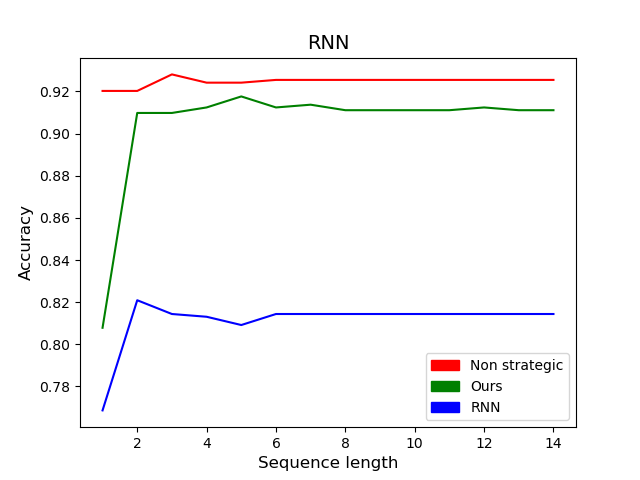

C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:51: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [53]:
l = 14
num_of_splits = 9
avg_non_strategic_acc = np.zeros(l)
avg_ours_acc = np.zeros(l)
avg_rnn_acc = np.zeros(l)

for i in range(1, num_of_splits + 1):

    path = "./models/FINAL/rnn/rnn___" + str(i)

    lengths = []
    non_strategic_acc = []
    ours_acc = []
    rnn_acc = []

    for root,d_names,f_names in os.walk(path):
        if "results.csv" in f_names:
            details = root.split("\\")
            seq_len = int(details[-1])
            acc = pd.read_csv(root + '/results.csv')
            acc = acc.values[:, 1]
            lengths.append(seq_len)
            non_strategic_acc.append(acc[0])
            ours_acc.append(acc[1])
            rnn_acc.append(acc[2])

    lengths = np.array(lengths)
    p = lengths.argsort()
    lengths = lengths[p]
    non_strategic_acc = np.array(non_strategic_acc)[p]
    ours_acc = np.array(ours_acc)[p]
    rnn_acc = np.array(rnn_acc)[p]


    avg_non_strategic_acc += non_strategic_acc[:l]
    avg_ours_acc += ours_acc[:l]
    avg_rnn_acc += rnn_acc[:l]


avg_non_strategic_acc /= num_of_splits
avg_ours_acc /= num_of_splits
avg_rnn_acc /= num_of_splits

fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('RNN')
plt.xlabel('Sequence length')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
ax.plot(lengths[:l], avg_non_strategic_acc, color='r')
ax.plot(lengths[:l], avg_ours_acc, color='g')
ax.plot(lengths[:l], avg_rnn_acc, color='b')

red_patch = mpatches.Patch(color='r', label='Non strategic')
green_patch = mpatches.Patch(color='g', label='Ours')
blue_patch = mpatches.Patch(color='b', label='RNN')

plt.legend(handles=[red_patch, green_patch, blue_patch])

# plt.savefig(path + '/rnn.pdf', format='pdf')
# plt.savefig(path + '/rnn.eps', format='eps')
# plt.savefig(path + '/rnn.png', format='png')
plt.show()

# Utility violin

<IPython.core.display.Javascript object>


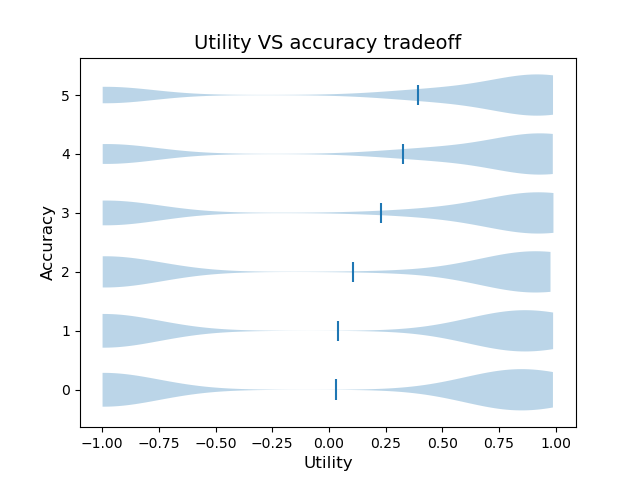

[0.69466667 0.69466667 0.70133333 0.69066667 0.67333333 0.67333333]


C:\Users\sagil\Anaconda3\envs\funcPred\lib\site-packages\ipykernel_launcher.py:31: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


In [32]:
utilities = []
accuracies = []
path = "./models/FINAL/utility/tradeoff"

all_utilities = pd.read_csv(path + '/All_utilities.csv')
all_utilities = all_utilities.values[:, 1:]

all_predictions = pd.read_csv(path + '/All_predictions.csv')
all_predictions = all_predictions.values[:, 1:]

all_true_lables = pd.read_csv(path + '/Ytest.csv')
all_true_lables = all_true_lables.values[:, 1]

for root,d_names,f_names in os.walk(path):
    if "val_utilities.csv" in f_names:
        val_utilities = pd.read_csv(root + '/val_utilities.csv')
        utility = val_utilities.values[-1][1]
        utilities.append(utility)
        val_errors = pd.read_csv(root + '/val_errors.csv')
        acc = 1 - val_errors.values[-1][1]
        accuracies.append(acc)
        

fig = plt.figure()

plt.rc('axes', titlesize=BIG_SIZE)
plt.rc('axes', labelsize=MEDIUM_SIZE)
plt.title('Utility VS accuracy tradeoff')
plt.xlabel('Utility')
plt.ylabel('Accuracy')
ax = fig.add_subplot(111)
print(np.array(accuracies)[[0, 10, 20, 30, 40, 43]])
ax.violinplot(all_utilities[[0, 10, 20, 30, 40, 43]].tolist(), [0, 1, 2, 3, 4, 5], vert=False, points=750, widths=0.7,
                      showmeans=True, showextrema=False, showmedians=False)

plt.show()

# Manifold

accuracies:  1.0 0.5225 0.9775 0.895
non_strategic_model_w:  [[-5.34599548]
 [ 0.28888565]]
non_strategic_model_b:  [-0.0116142]
strategic_model_naive_w:  [[-0.43831753]
 [ 0.01909347]]
strategic_model_naive_b:  [-2.70338873]
strategic_model_man_w:  [[-1.71241649]
 [-0.32299349]]
strategic_model_man_b:  [-5.22422495]


<IPython.core.display.Javascript object>


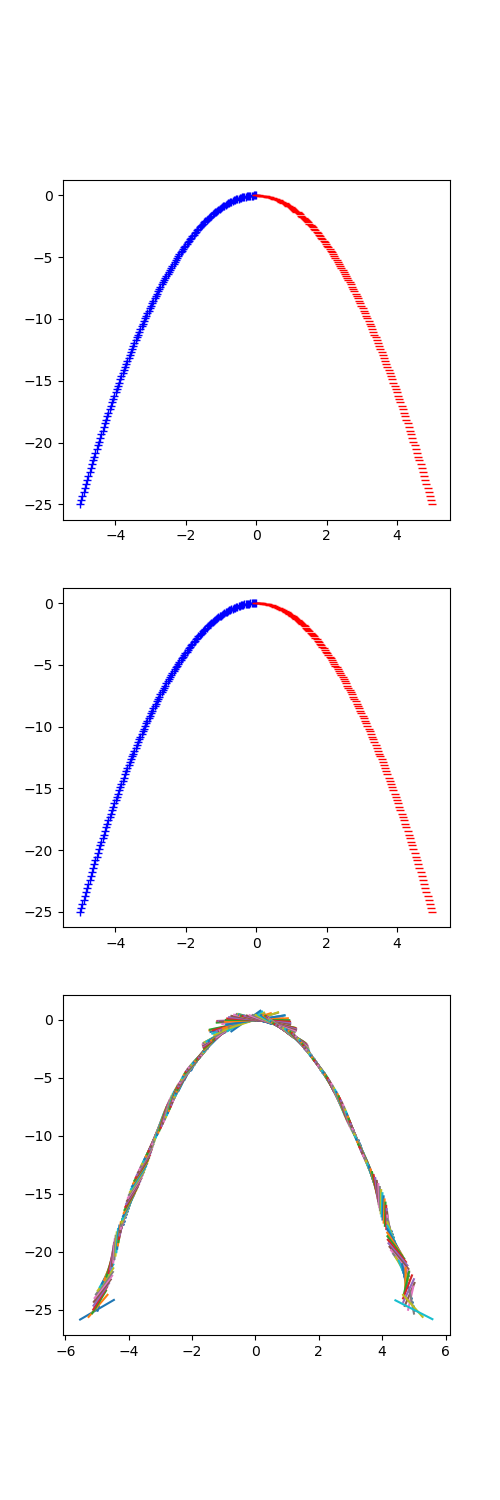

In [5]:
path = "./models/FINAL/manifold/parabula"

accuracies = pd.read_csv(path + '/results.csv')
accuracies = accuracies.values[:, 1]
non_strategic_acc = accuracies[0]
strategic_naive_acc = accuracies[1]
strategic_manifold_acc = accuracies[2]
svm_acc = accuracies[3]

print("accuracies: ", non_strategic_acc, strategic_naive_acc, strategic_manifold_acc, svm_acc)

non_strategic_model_w = pd.read_csv(path + '/non_strategic_model_w.csv').values[:, 1:]
non_strategic_model_b = pd.read_csv(path + '/non_strategic_model_b.csv').values[:, 1]
strategic_model_naive_w = pd.read_csv(path + '/strategic_model_naive_w.csv').values[:, 1:]
strategic_model_naive_b = pd.read_csv(path + '/strategic_model_naive_b.csv').values[:, 1]
strategic_model_man_w = pd.read_csv(path + '/strategic_model_man_w.csv').values[:, 1:]
strategic_model_man_b = pd.read_csv(path + '/strategic_model_man_b.csv').values[:, 1]

print("non_strategic_model_w: ", non_strategic_model_w)
print("non_strategic_model_b: ", non_strategic_model_b)
print("strategic_model_naive_w: ", strategic_model_naive_w)
print("strategic_model_naive_b: ", strategic_model_naive_b)
print("strategic_model_man_w: ", strategic_model_man_w)
print("strategic_model_man_b: ", strategic_model_man_b)

X = pd.read_csv(path + '/X.csv')
X = X.values[:, 1:]
Y = pd.read_csv(path + '/Y.csv')
Y = Y.values[:, 1]
H = pd.read_csv(path + '/H.csv')
H = H.values[:, 1]
X_recons = pd.read_csv(path + '/X_reconstructed.csv')
X_recons = X_recons.values[:, 1:]
B = pd.read_csv(path + '/spans.csv')
B = B.values[:, 1:]

Xpos = X[Y == 1]
Xneg = X[Y == -1]
Xpos_recons = X[Y == 1]
Xneg_recons = X[Y == -1]

fig = fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(5, 15))

axes[0].scatter(Xpos[:, 0], Xpos[:, 1], marker='+', color='b', linewidths=1)
axes[0].scatter(Xneg[:, 0], Xneg[:, 1], marker='_', color='r', linewidths=1)

axes[1].scatter(Xpos_recons[:, 0], Xpos_recons[:, 1], marker='+', color='b', linewidths=1)
axes[1].scatter(Xneg_recons[:, 0], Xneg_recons[:, 1], marker='_', color='r', linewidths=1)

axes[2].scatter(X[:, 0], X[:, 1], s=1)
for x, b in zip(X, B):
    xm = x-b
    xp = x+b
    axes[2].plot([xm[0], xp[0]], [xm[1], xp[1]])

plt.show()
